# Bayesian sampling for simple PK


In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

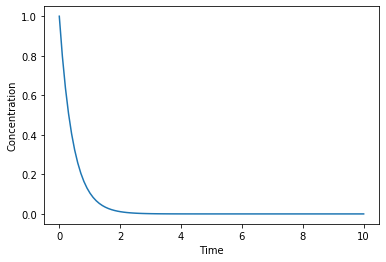

In [6]:
# Parameters
k = 2
times = np.linspace(0,10,100)

# A one-compartment PK model is basically an ODE for an exponential decay curve
def onecomp(y, t, k):
    dydt = -k * y
    return dydt

# You can solve ODEs with the Forward Euler method
def ForwardEuler(func, k, y0, times):
    y = y0
    y_solution = [y0]
    h = times[2] - times[1]
    
    for n in times[:-1]:
        dy = func(y, n, k)
        y = y + h*dy
        y_solution.append(y)

    return y_solution

# We don't actually know these values
actual_values = ForwardEuler(onecomp, k, 1, times)

# Plot the model
plt.figure()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.plot(times, actual_values)
plt.show()

Without prior knowledge, we can make a guess at a model type that would give this kind of data, but we don't know what the parameters of the model are. We call these parameters theta ($\theta$) and in this single-compartment case the only parameter is k.

While we can estimate concentration (y(t)) at a given time (t) numerically by plotting from y(0), we have to guess a value of k. **We are trying to find the true value of k**.

You could measure from the system we're modelling, and you would get measurements with some measurement error, which we're modelling as gaussian noise below.

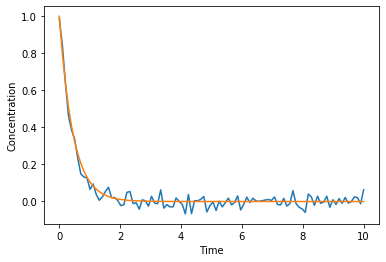

In [9]:
# Make noisy data that we're inferring from. noisy_data is known to us.
noise = np.random.normal(0, 0.03, len(actual_values))
noisy_data = actual_values + noise
plt.figure()
plt.plot(times, noisy_data)
plt.plot(times, actual_values)
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()

**Metropolis sampling**

Assuming that our only two inputs ($\theta$) are k (gradient scaling) and $\sigma$ (SD of noise)...

We want to find $Pr(\theta|X)$ (the posterior), which is a function giving the probability distribution for the model input parameters: that is, for each possible combination of input parameters, a likelihood that that is the combination producing this output. Input $\theta$ (vector, output probability density (scalar).

$Pr(\theta|X) = \frac{Pr(X|\theta) Pr(\theta)}{Pr(X)}$  
RHS has three parts: 
- $Pr(\theta)$: prior. Function that gives a probability density (scalar) from $\theta$ (vector). Here, gives 0.1 for all values of k & $\sigma$ between 0 and 10.
- $Pr(X|\theta)$: likelihood. It's just a crazy function that takes $\theta$ and gives a scalar. Accept and move on.
- $Pr(X)$: A number that normalises (makes the posterior integrate to 1).

**Steps**
1. Start with an arbitrary $\theta$ (a k and a $\sigma$). Calculate prior x likelihood.
2. Move to a different $\theta$ (+/- an amount from a normal distribution with SD given by the 'covariate matrix'). Calculate prior x likelihood.
3. If new prior x likelihood is higher than old, keep it and add the new $\theta$ to a list. If not, keep it if rand(0->1) > (old/new). If neither of these work, move back to the old one and add that instead.
4. Repeat steps 2-3 for N steps. 
5. Count your list of $\theta$s into bins and draw a histogram. This approximates your posterior.

In [17]:
# This model stores all the model-related variables, so there's less weird passing of vars between functions

class OdeModel():
    
    def __init__(self, thetas, covariates, prior, likelihood, modeltype):
        self.thetas = thetas
        self.covariates = covariates
        self.modeltype = modeltype
        self.prior = prior
        self.likelihood = likelihood
        self.log = {'zero':0, 'large':0, 'frac':0, 'allfracs':[], 'sumlogprob':[], 'fn_mean':[]}

In [12]:
# This gives a uniform prior theta ~ U(0,10) 
# so 0.1 if theta is anywhere between 0 and 10 it gives 0.1, else 0

def uniform_prior(theta):

    prior = []
    for key, param in theta.items():
        if type(param) == list:
            print('DEBUG: THIS IS PARAM')
            print(param)
        if param > 0 and param < 10:
            prior.append(0.1)
        else:
            prior.append(0)
            
    return min(prior)

In [11]:
# This calculates the likelihood 
# (probability that theta could give the output y_data)

def likelihood_k(theta, y_data):
    k = theta['k']
    sigma = 0.03
    pdf = []
    y_model = ForwardEuler(onecomp, k, 1, times)
    other_bit = 1/(2*math.pi*sigma**2)
    for t in range(len(y_data)): # this loop gives a normally distributed pdf
        square_error = (y_data[t] - y_model[t])**2
        exponential = math.exp(-square_error/(2*sigma**2))
        pdf.append(exponential*other_bit)
    
    return np.prod(pdf)

In [18]:
# This does steps 2 & 3 in the instructions above.
# It takes the model and measured data
# It gives ...

def propose_new_theta(model, y_data, theta):

    numerator = model.prior(theta) * model.likelihood(theta, y_data)
    
    # randomly get a proposed theta & calculate its numerator
    proposed_theta = {}
    for key, value in theta.items():
        proposed_k = np.random.normal(value, model.covariates[key])
        proposed_theta[key] = proposed_k
    proposed_numerator = model.prior(proposed_theta) * model.likelihood(proposed_theta, model.y, y_data)
    
    # if the new numerator should be accepted (metropolis hastings criteria), replace theta
    if proposed_numerator == 0:
        model.log['zero'] += 1
        pass
    elif proposed_numerator > numerator:
        theta = proposed_theta
        numerator = proposed_numerator
        model.log['large'] += 1
    elif np.random.rand() < proposed_numerator/numerator:
        model.log['frac'] += 1
        model.log['allfracs'].append(proposed_numerator/numerator)
        theta = proposed_theta
        numerator = proposed_numerator
    else:
        model.log['allfracs'].append(proposed_numerator/numerator)
    return theta



NameError: name 'model' is not defined

In [19]:
# This just runs propose_new_theta repeatedly

def metropolis_singlethread(model, y_data, threadnum, max_iters):
    iters = 0
    
    while iters < max_iters:
        theta = propose_new_theta(model, y_data, model.thetas[threadnum][-1])
        model.thetas[threadnum].append(theta)
        iters = iters + 1

In [20]:
def metropolishastings(model, y_data, blocksize, number_of_blocks):
    n = 0
    while n < number_of_blocks:
        for threadnum, thetas_onelot in enumerate(model.thetas):
            metropolis_singlethread(model, y_data, threadnum, blocksize)
        n = n+1

Let'